### Data Analyst Assignment for Streamlabs 
### Problem 2
### Kris Grant
### July 28, 2022

In [1]:
#getting all the modules!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Data ingestion and processing

##### Cleaning summary
- Examined observations with NA values: remediation decision to keep since only Game field was NA and hours_watched is needed for summary calculations.
- Removed duplicate observations
- Reformatted Hours_streamed field to remove text and cast as integer. 
- Reformatted Game to all lower case for easier selection on string matching
- Elected to ignore columns Avg_viewers, Avg_channels, Avg_viewer_ratio due to unclear calculation.
- Added a combined date column with format yyyymm for easier selection and plotting.
- Added columns calculating Hours streamed / streamer and hours viewed / hours streamed.

In [2]:
#loading and viewing data
df = pd.read_csv('Twitch_Game_Data.csv')
df.head(2)
# unclear calculations avg_viewers and avg_channels - per game per stream per month maybe?
# will need to strip text from hours_streamed

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044 hours,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105 hours,372654,2197,120849,64378,1117,57.62


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14421 entries, 0 to 14420
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              14421 non-null  int64  
 1   Game              14420 non-null  object 
 2   Month             14421 non-null  int64  
 3   Year              14421 non-null  int64  
 4   Hours_watched     14421 non-null  int64  
 5   Hours_Streamed    14421 non-null  object 
 6   Peak_viewers      14421 non-null  int64  
 7   Peak_channels     14421 non-null  int64  
 8   Streamers         14421 non-null  int64  
 9   Avg_viewers       14421 non-null  int64  
 10  Avg_channels      14421 non-null  int64  
 11  Avg_viewer_ratio  14421 non-null  float64
dtypes: float64(1), int64(9), object(2)
memory usage: 1.3+ MB


In [4]:
df.describe().T
# zero values in streamers and avg_channels

,count,mean,std,min,25%,50%,75%,max
Rank,14421.0,1.005783e+02,5.774765e+01,1.00,51.00,101.00,151.00,2.670000e+02
Month,14421.0,6.504334e+00,3.451717e+00,1.00,4.00,7.00,10.00,1.200000e+01
Year,14421.0,2.018498e+03,1.707355e+00,2016.00,2017.00,2018.00,2020.00,2.021000e+03
Hours_watched,14421.0,4.775925e+06,1.666768e+07,89811.00,367456.00,818846.00,2293166.00,3.445520e+08
Peak_viewers,14421.0,5.503862e+04,1.328341e+05,441.00,8344.00,20133.00,45960.00,3.123208e+06
Peak_channels,14421.0,5.859775e+02,2.719506e+03,1.00,51.00,122.00,317.00,1.298600e+05
Streamers,14421.0,1.720291e+04,5.449481e+04,0.00,1481.00,4117.00,10697.00,1.013029e+06
Avg_viewers,14421.0,6.544832e+03,2.284315e+04,120.00,503.00,1122.00,3154.00,4.792090e+05
Avg_channels,14421.0,2.145736e+02,7.433462e+02,0.00,16.00,43.00,121.00,1.378900e+04
Avg_viewer_ratio,14421.0,8.179087e+01,3.686164e+02,1.95,16.14,29.15,57.72,1.360187e+04


In [5]:
# cleanup!

# checking for null values
# df.isna().sum()
# df[df['Game'].isna()]
# February 2019 has NA in Game at Rank 162
# df = df.dropna()
# Since I'm only looking at titles for the top 10 but I am summing hours, I'll leave the NA observation in the dataset.

# checking category counts
# df.Rank.value_counts()

# should be 72 per rank, checking for duplicates & dropping
# df[df.duplicated()]
df = df.drop_duplicates()

In [6]:
df.Rank.value_counts()
# one more straggler hanging out at rank 267

8      72
101    72
21     72
29     72
37     72
       ..
162    72
170    72
178    72
186    72
267     1
Name: Rank, Length: 201, dtype: int64

In [7]:
# dropping rank 267 Hello Kitty Island Adventure as extraneous (201 ranks in Nov 2017)
# df.query('Rank==267')
# df.query('Year==2017 and Month==11')
df = df[df.Rank != 267]

In [8]:
# transformations!
# making strings lowercase
df['Game'] = df['Game'].str.lower()

# stripping hours text out of streamed_hours
df['Hours_Streamed'] = df['Hours_Streamed'].str.split(expand=True)[0].astype(int)

# adding concatenated date column for exploratory
df['YearMonth'] = df['Year']*100+df['Month']

# adding ratio columns, accounting for 0 values in streamers field
df['Hr_per_Streamer'] = np.where(df['Streamers'] == 0, np.NaN, df['Hours_Streamed']/df['Streamers'])
df['View_to_Stream'] = df['Hours_watched']/df['Hours_Streamed']

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,14400.0,1.005000e+02,5.773631e+01,1.000000,50.750000,100.500000,1.502500e+02,2.000000e+02
Month,14400.0,6.500000e+00,3.452172e+00,1.000000,3.750000,6.500000,9.250000e+00,1.200000e+01
Year,14400.0,2.018500e+03,1.707884e+00,2016.000000,2017.000000,2018.500000,2.020000e+03,2.021000e+03
Hours_watched,14400.0,4.782448e+06,1.667895e+07,89811.000000,368056.500000,819869.500000,2.295376e+06,3.445520e+08
Hours_Streamed,14400.0,1.571197e+05,5.428111e+05,19.000000,12212.500000,31638.000000,8.871850e+04,1.024570e+07
Peak_viewers,14400.0,5.509512e+04,1.329134e+05,441.000000,8352.500000,20169.500000,4.598150e+04,3.123208e+06
Peak_channels,14400.0,5.867592e+02,2.721411e+03,1.000000,51.750000,122.000000,3.180000e+02,1.298600e+05
Streamers,14400.0,1.722478e+04,5.453153e+04,0.000000,1479.500000,4126.000000,1.071425e+04,1.013029e+06
Avg_viewers,14400.0,6.553785e+03,2.285860e+04,120.000000,504.000000,1125.000000,3.158000e+03,4.792090e+05
Avg_channels,14400.0,2.148591e+02,7.438503e+02,0.000000,16.000000,43.000000,1.210000e+02,1.378900e+04


#### The state of streaming


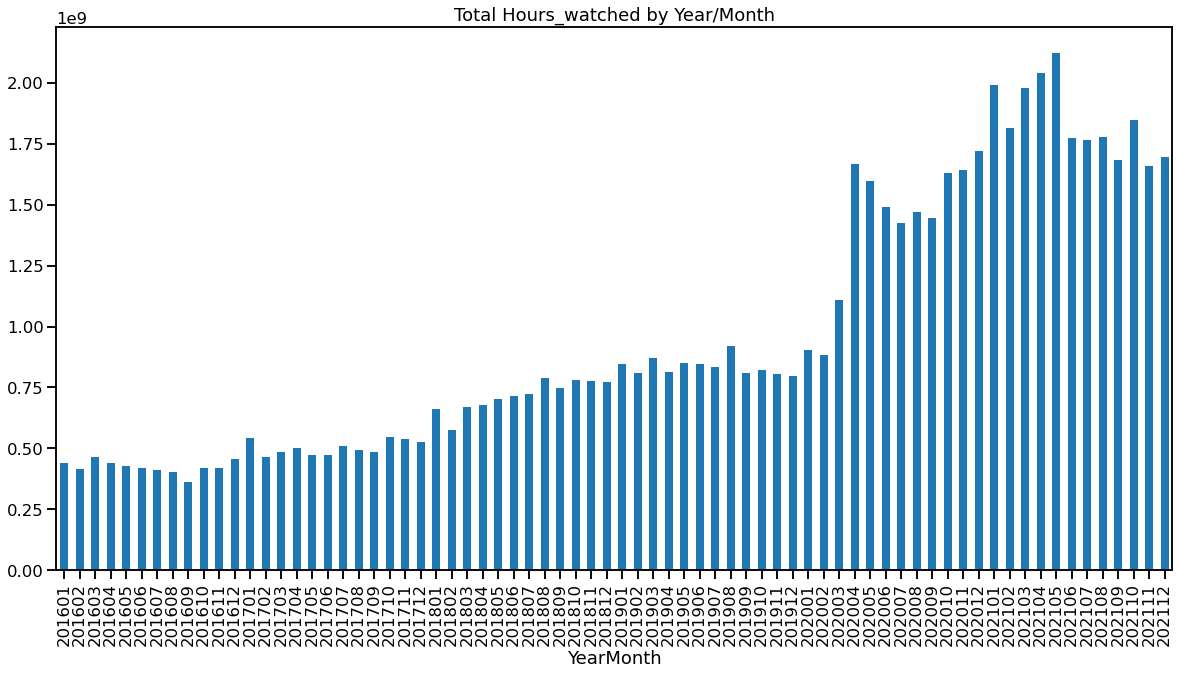

In [9]:
# plotting total hours_watched my month
sns.set_context("talk")

df.groupby('YearMonth').Hours_watched.sum().plot(kind='bar', figsize=(20,10), title="Total Hours_watched by Year/Month")
plt.show()

There is significant growth in hours_watched starting April 2020, which is not a surprise given the global implementation of COVID restrictions. Social distancing and the resulting increase in amount of time spent at home created more available hours for consumers to seek entertainment.  
In the time period prior to COVID, there are local maxima around January & August in multiple years. Since this timing coincides with a typical school schedule, one potential explanation for the maxima is a burst in available time during the month just before a new semester starts. 

League of Legends has been in the top 5 streams ~50% more than any other game. 

In [10]:
# top games by # months in top 5 spot
df_top = df.iloc[:, 0:5].query('Rank <= 5')
print('Games Sorted by # of Top 5 Ranks')
df_top.Game.value_counts().head(10)

Games Sorted by # of Top 5 Ranks


league of legends                   72
fortnite                            42
dota 2                              42
just chatting                       39
counter-strike: global offensive    34
hearthstone                         28
grand theft auto v                  21
playerunknown's battlegrounds       17
call of duty: warzone               11
overwatch                            9
Name: Game, dtype: int64

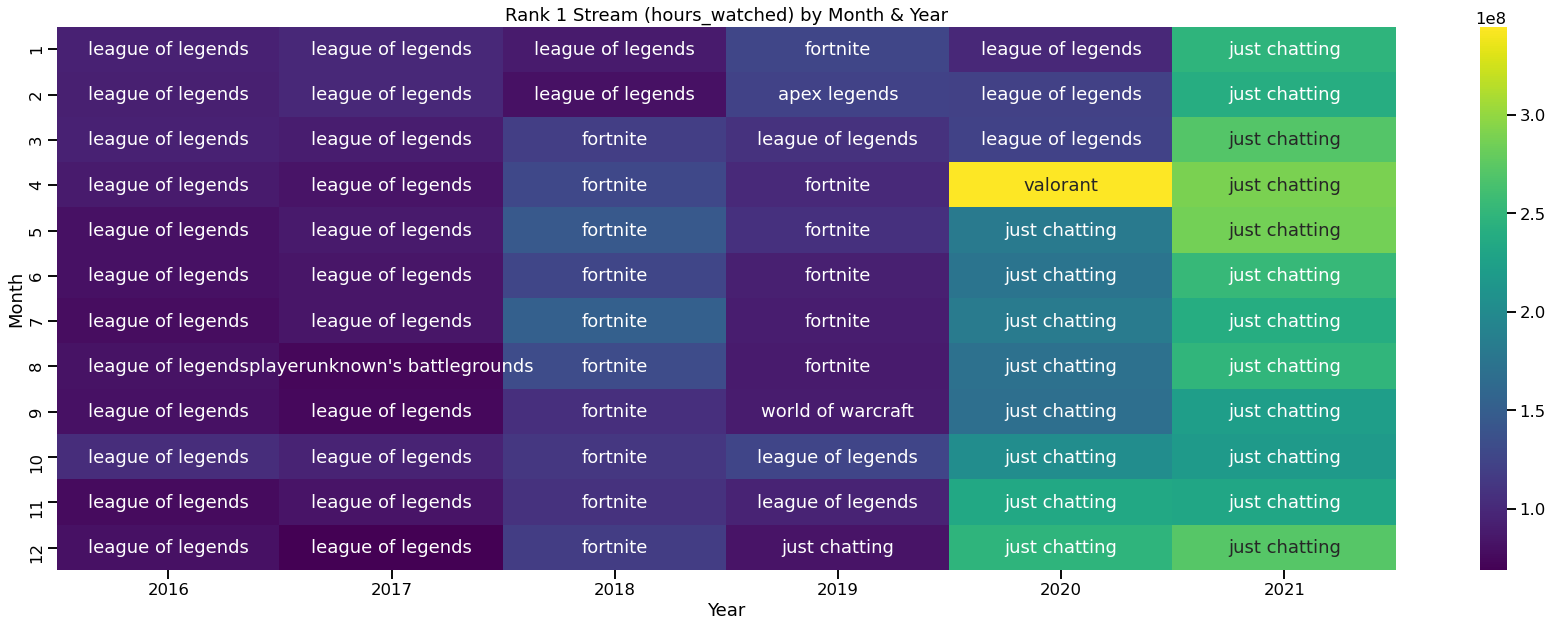

In [11]:
# rank 1 game by month and year
# pivot & heatmap
df_one = df.iloc[:,np.r_[0:5,12:15]].query('Rank==1')
one_map = df_one.pivot('Month', 'Year', 'Hours_watched')
labels = df_one.pivot('Month', 'Year', 'Game')
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(one_map, annot = labels, fmt='', cmap='viridis')
plt.title("Rank 1 Stream (hours_watched) by Month & Year")
plt.show()

League of Legends & Fortnite have the majority share of rank 1 prior to COVID with Just Chatting taking over rank 1 after COVID. There are a handful of single game upsets to trend (PUBG, Apex Legends, WoW, and Valorant) which coincide with their respective release dates. 

In [12]:
# what does rank 1 look like without 'just chatting'?
# ensuring the dataframe is sorted appropriately
df_sort = df.sort_values(["YearMonth","Rank"], axis = 0, ascending = True)

# adding columns for rank 2 replacements when rank 1 is 'just chatting' 
df_sort['NextRank'] = df['Game'].shift(-1)
df_sort['NextHours'] = df['Hours_watched'].shift(-1)

# filter to rank 1 records
new_rank = df_sort.iloc[:,np.r_[0:5,13:17]].query('Rank==1')

# adding columns of new game and hours that replace 'just chatting' with 2nd place values
new_rank['NewGame'] = np.where(new_rank['Game'] == 'just chatting', new_rank['NextRank'], new_rank['Game'])
new_rank['NewHours'] = np.where(new_rank['Game'] == 'just chatting', new_rank['NextHours'], new_rank['Hours_watched'])

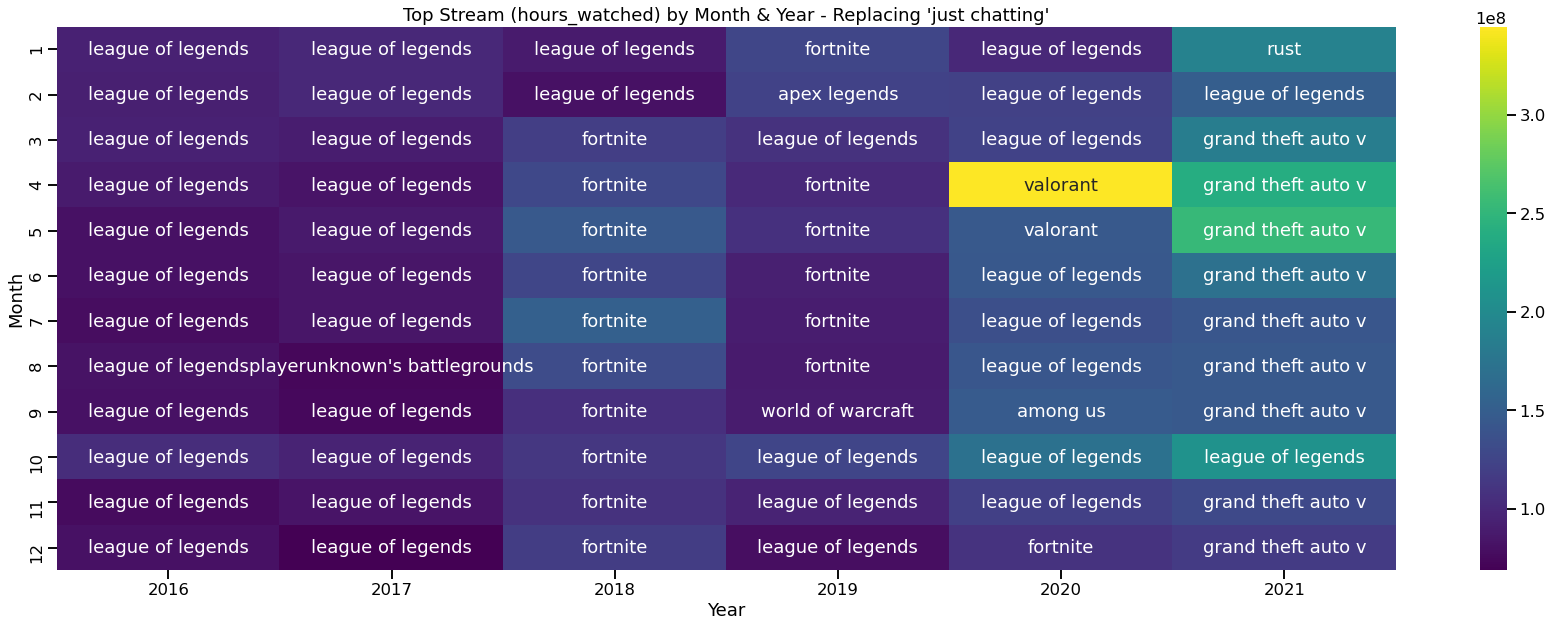

In [13]:
# pivot & heatmap
new_map = new_rank.pivot('Month', 'Year', 'NewHours')
new_labels = new_rank.pivot('Month', 'Year', 'NewGame')
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(new_map, annot = new_labels, fmt='', cmap='viridis')
plt.title("Top Stream (hours_watched) by Month & Year - Replacing 'just chatting'")
plt.show()

By replacing Just Chatting with the Rank 2 game an interesting shift gains visibility. GTAV joins the top grouping 9 out of 12 months in 2021.
Initially the success of rust in January 2021 threw me since it is an older title without any standout releases at the time. Some searching revealed that Rust's appearance in January is likely due to featured Twitch partnership. https://comicbook.com/gaming/news/rust-january-2021-update-twitch-drops-pokimane-shroud-xqc/

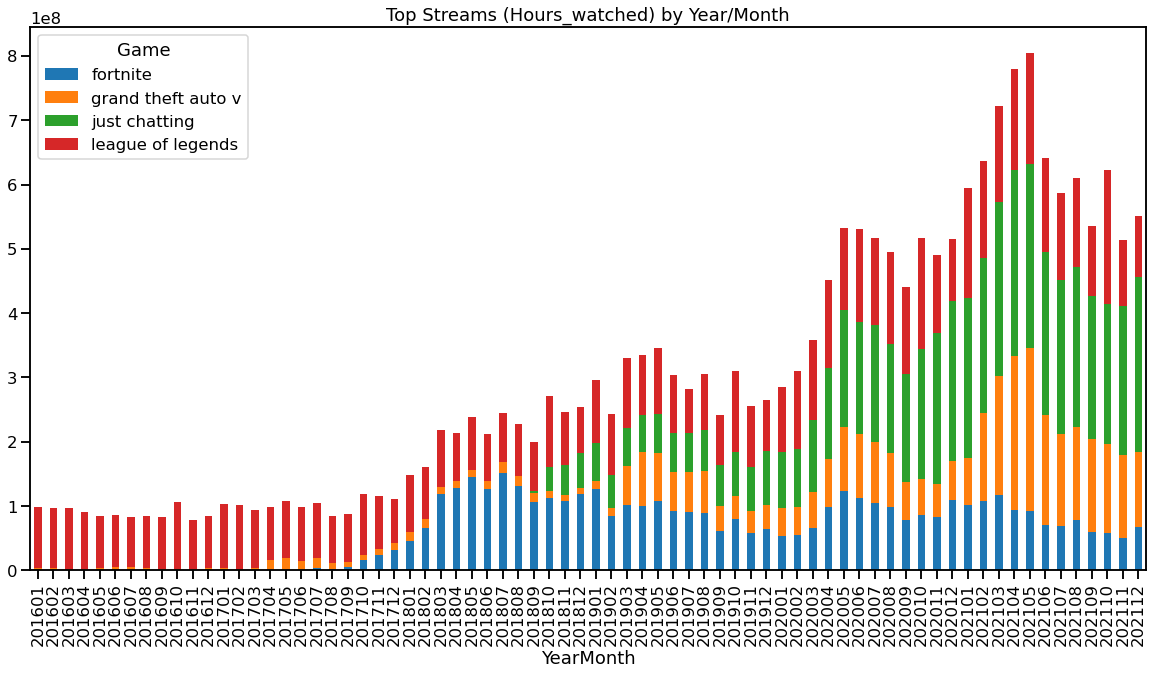

In [14]:
# the top games
tg = df.query("Game=='league of legends' or Game=='fortnite' or Game=='just chatting' or Game=='grand theft auto v'")
tg_map = tg.pivot('YearMonth', 'Game', 'Hours_watched')
tg_map.plot(kind='bar', stacked=True, figsize=(20,10), title='Top Streams (Hours_watched) by Year/Month')
plt.show()

- GTAV gained significant increases in viewership in March 2019, April 2020, and February 2021. 
- League of Legends has consistent viewership with modest increases post COVID.
- Fortnite released strong but struggles against declining viewership.
- Just Chatting gained viewership in October 2018 and exploded post COVID.

##### What share of monthly hours are rank 1 streams?

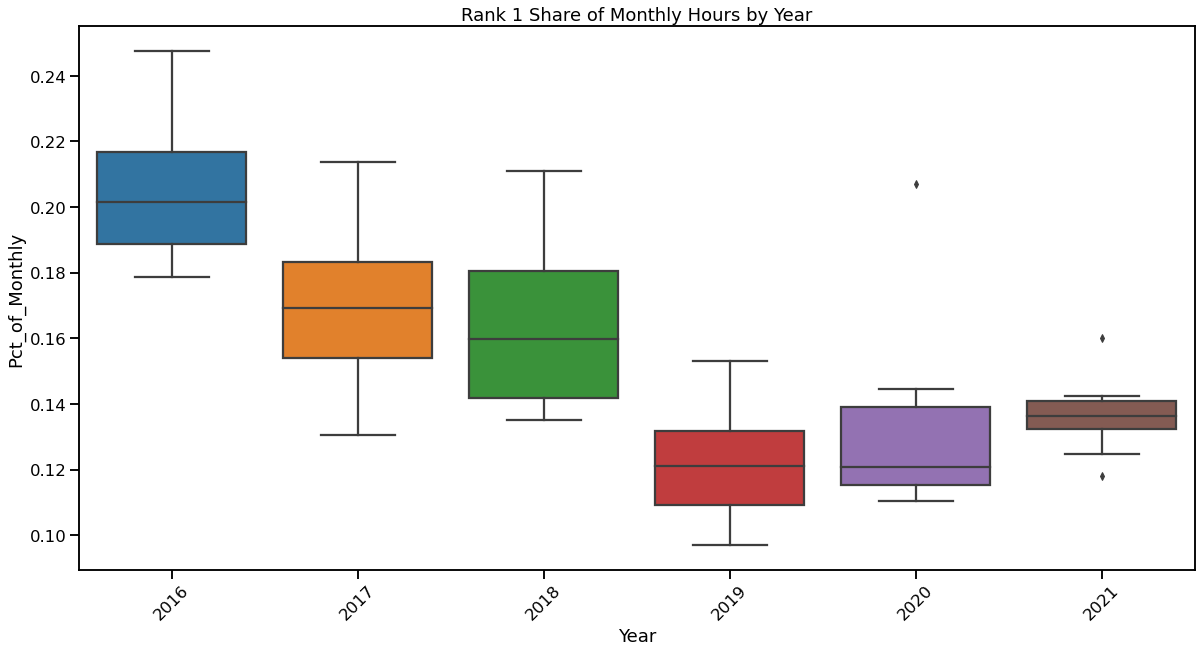

In [15]:
# grouping and getting sum of hours by month, adding percentage share column
monthly = df.groupby('YearMonth').Hours_watched.sum()
df_one['Monthly_watched'] = monthly.values
df_one['Pct_of_Monthly'] = df_one['Hours_watched']/df_one['Monthly_watched']
# boxplot
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df_one, x='Year', y='Pct_of_Monthly')
plt.xticks(rotation=45)
plt.title("Rank 1 Share of Monthly Hours by Year")
plt.show()

The top streams in 2016 had, on average, over 20% of the total monthly hours whereas the top streams in 2021 had around 14% of the total monthly hours - combined with the increase in overall hours since 2020, this could indicate that viewers are spreading time over more streams.
Would be interesting to see if streams viewed per unique viewer has also changed.

#### How do the hours streamed compare to the hours viewed?

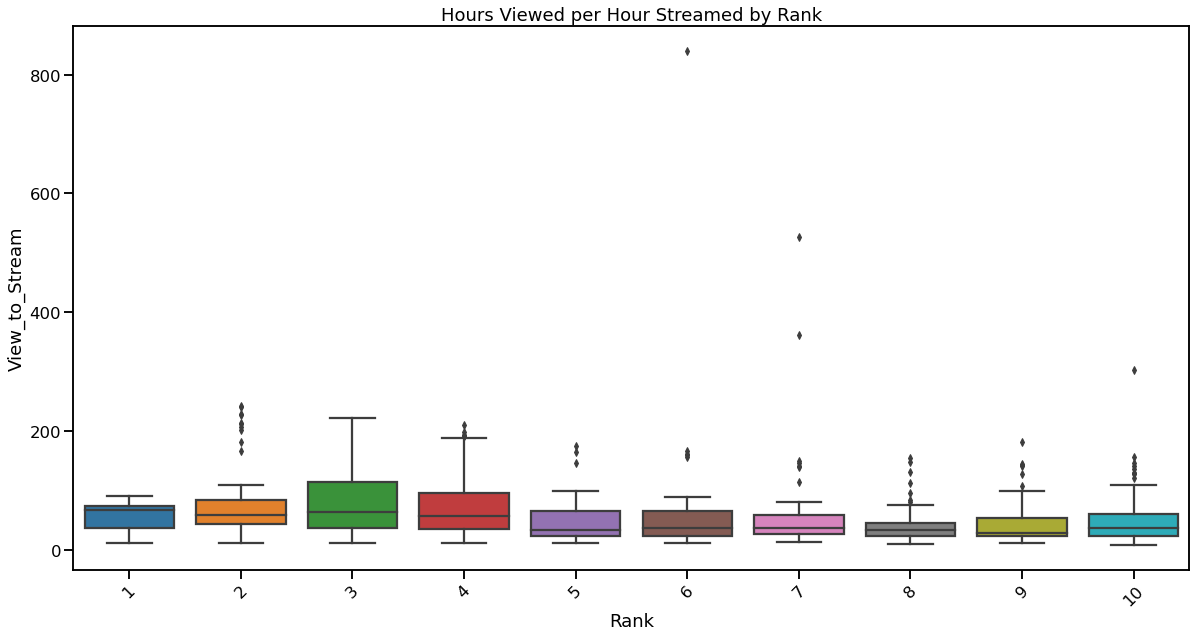

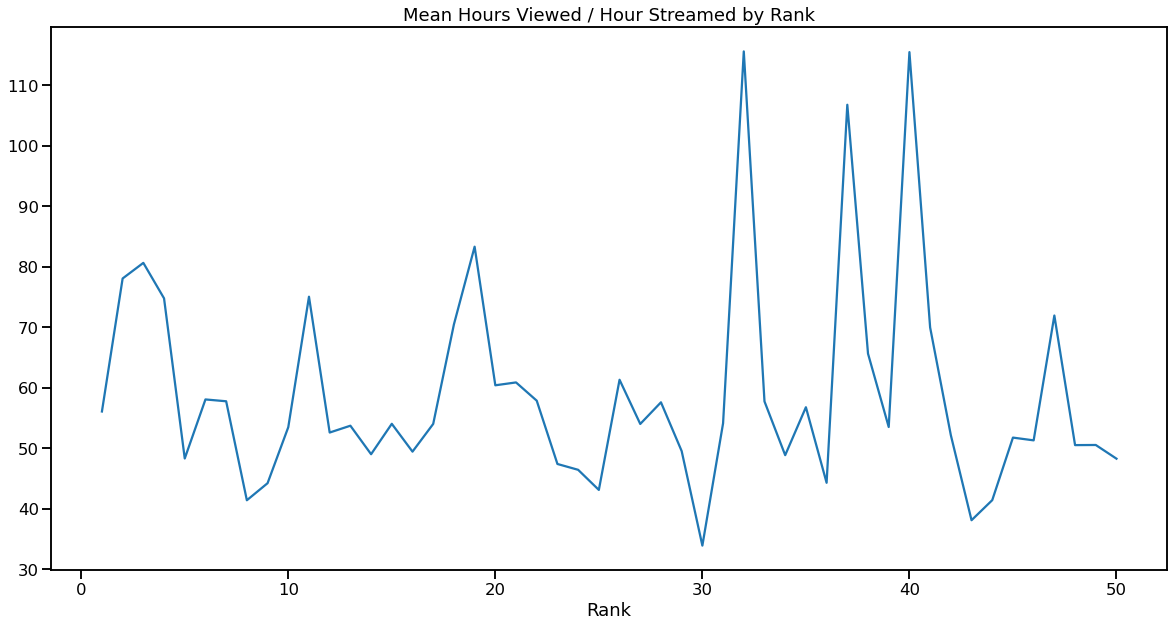

In [16]:
# boxplot
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df.query('Rank<=10'), x='Rank', y='View_to_Stream')
plt.xticks(rotation=45)
plt.title("Hours Viewed per Hour Streamed by Rank")
plt.show()
# mean trend
df.query('Rank<=50').groupby('Rank').View_to_Stream.mean().plot(figsize=(20,10), title='Mean Hours Viewed / Hour Streamed by Rank')
plt.show()

On average, rank 1 streams actually have less hours viewed per hour streamed than rank 2, 3, and 4. The overall trend of average hours viewed per hour streamed is quite flat.

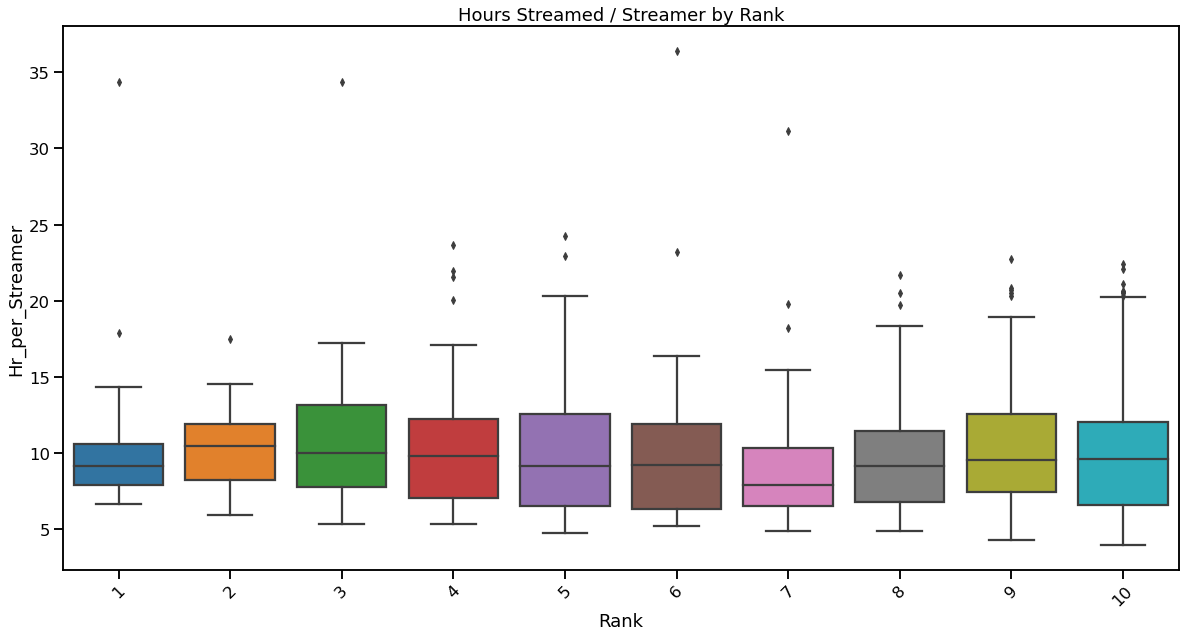

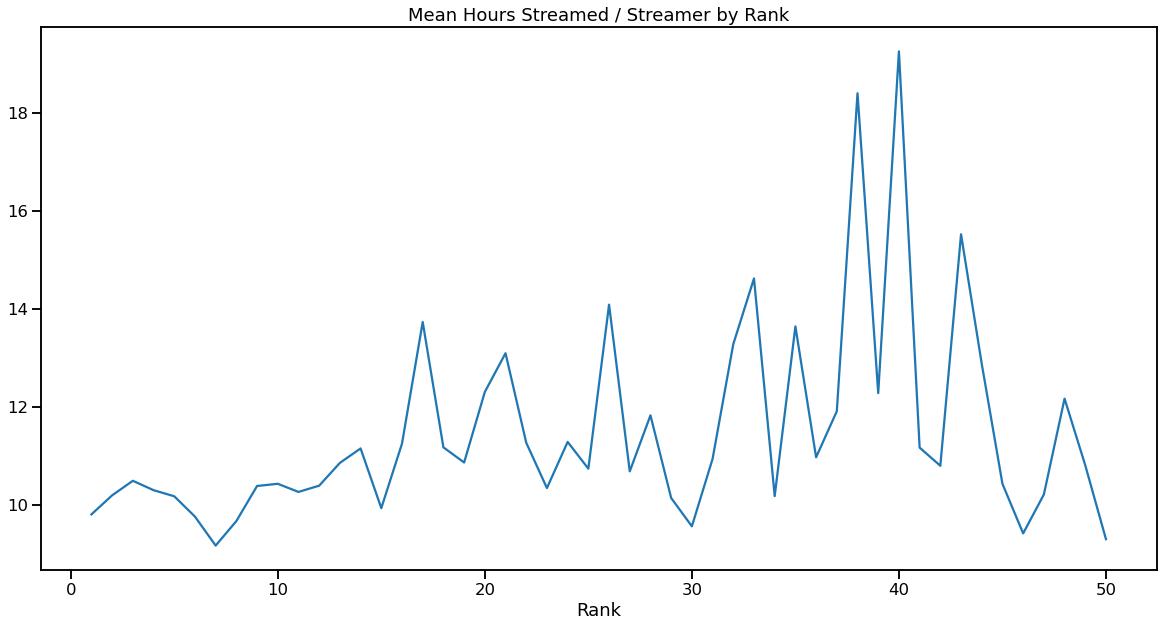

In [17]:
# boxplot
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df.query('Rank<=10'), x='Rank', y='Hr_per_Streamer')
plt.xticks(rotation=45)
plt.title("Hours Streamed / Streamer by Rank")
plt.show()
# mean trend
df.query('Rank<=50').groupby('Rank').Hr_per_Streamer.mean().plot(figsize=(20,10), title='Mean Hours Streamed / Streamer by Rank')
plt.show()

Similarly the hours streamed per streamer for rank 1 streams were less than those of rank 2, 3, and 4 on average. It appears neither the hours viewed to hour streamed ratio or hours streamed per streamer ratio are reliable indicators of ranking. 

#### How many hours are the 1st outranking the 2nd? the 2nd outranking the 3rd?

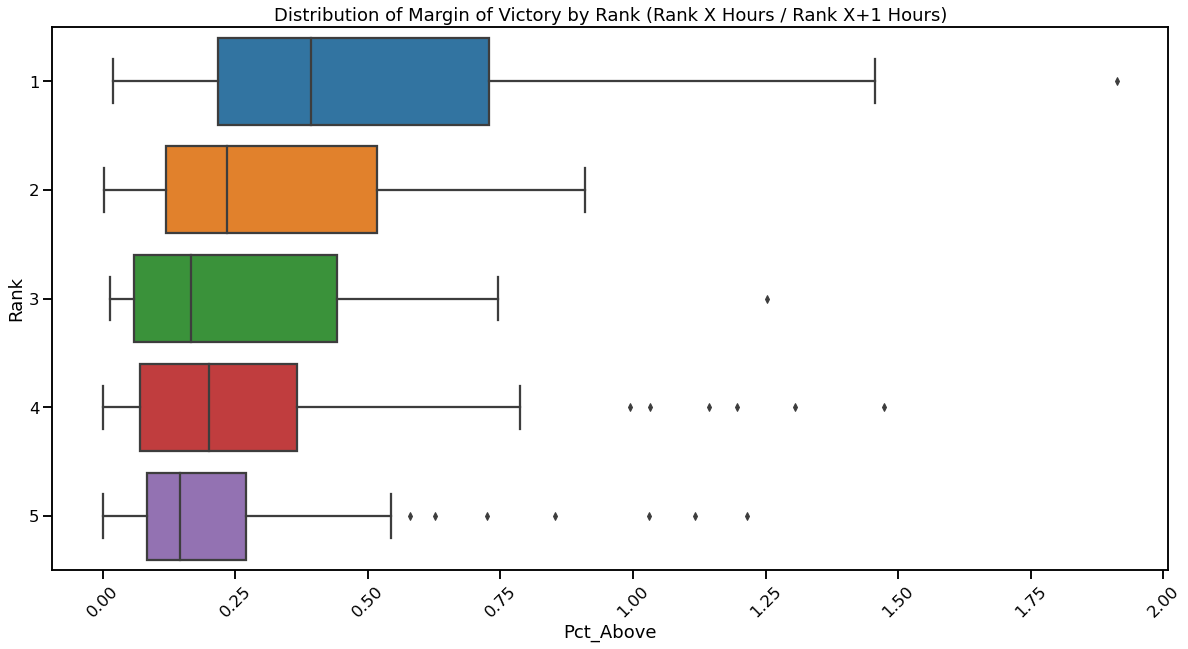

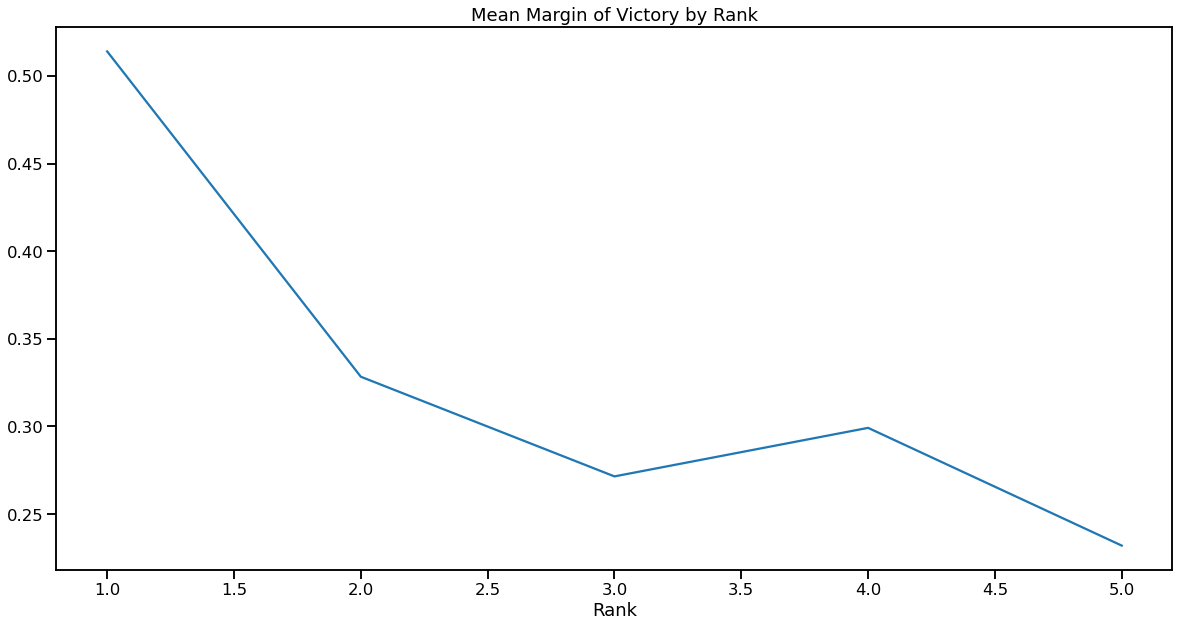

In [18]:
# adding calculation for current hours_watched / next rank hours_watched (rank1/rank2, rank2/rank3)
outrank = df_sort.iloc[:,np.r_[0:5,13:17]].query('Rank<=5')
outrank['Pct_Above'] = outrank['Hours_watched']/outrank['NextHours']-1
# boxplot
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=outrank, y='Rank', x='Pct_Above', orient='h')
plt.xticks(rotation=45)
plt.title("Distribution of Margin of Victory by Rank (Rank X Hours / Rank X+1 Hours)")
plt.show()
# mean trend
outrank.groupby('Rank').Pct_Above.mean().plot(figsize=(20,10), title='Mean Margin of Victory by Rank')
plt.show()

Streams in rank 1 outrank 2nd place by over 50% on average while streams in rank 2 outrank 3rd place by 32% on average. As standing decreases, the margin of victory narrows - demonstrated by the shrinking interquartile ranges and decreasing mean.

#### Final thoughts

Global restrictions around COVID drove a very significant increase in the amount of hours viewed on Twitch. Changes in the type of content viewed (increase in Just Chatting, GTAV) might indicate a similar increase in users new to the platform. As COVID restrictions ease, it is likely there will be a decline in hours providing an opportunity for Twitch to optimize it's strategy for retaining users. 

The content is relevant and the largest variable to consider. By removing the Just Chatting category, it is even more apparent that success follows a handful of titles with occasional breakouts due to new releases or events. Twitch as a platform and business has a larger lever than content creators (increasing hours streamed won't shift the trend). The pull of Twitch as a platform can be seen in the partnerships with content creators that have the magnitude to break stale titles into the top performers (Rust, Janaury 2021). 


Further analysis for consideration:
- counts of users by month and stream: is there an increase in hours viewed per user or just more users? 
- similar data by content creator: what share of volume do influencers drive?
- performance segmentation between AAA and indie developed games: define success in context to better highlight the standout performers.

